In [27]:
%pip install -U xgboost


   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 487.6 kB/s eta 0:03:25
   ---------------------------------------- 0.1/99.8 MB 656.4 kB/s eta 0:02:32
   ---------------------------------------- 0.2/99.8 MB 1.1 MB/s eta 0:01:35
   ---------------------------------------- 0.3/99.8 MB 1.4 MB/s eta 0:01:14
   ---------------------------------------- 0.5/99.8 MB 2.0 MB/s eta 0:00:50
   ---------------------------------------- 1.0/99.8 MB 3.4 MB/s eta 0:00:29
    --------------------------------------- 1.5/99.8 MB 4.4 MB/s eta 0:00:23
    --------------------------------------- 2.3/99.8 MB 5.9 MB/s eta 0:00:17
   - -------------------------------------- 3.3/99.8 MB 7.5 MB/s eta 0:00:13
   - -------------------------------------- 3.3/99.8 MB 7.5 MB/s eta 0:00:13
   - -------------------------------------- 3.7/99.8 MB 7.1 MB/s eta 0:00:14
   - ---

In [28]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import xgboost as xgb

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
full_data = [train_df, test_df]
all_data_df = pd.concat(full_data)

In [6]:
train_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [9]:
train_df_na = ((train_df.isnull().sum()) / len(train_df)) * 100
test_df_na = ((test_df.isnull().sum()) / len(test_df)) * 100
all_data_df_na = ((all_data_df.isnull().sum()) / len(all_data_df)) * 100


missing_df = pd.DataFrame({'Missingness - Train':train_df_na, \
                           'Missingness - Test':test_df_na,'Missingness - All':all_data_df_na})
missing_df = missing_df.sort_values(by=['Missingness - Train'], ascending=False)
missing_df.head(15)

,Missingness - Train,Missingness - Test,Missingness - All
PoolQC,99.520548,99.794380,99.657417
MiscFeature,96.301370,96.504455,96.402878
Alley,93.767123,92.666210,93.216855
Fence,80.753425,80.123372,80.438506
MasVnrType,59.726027,61.274846,60.500171
FireplaceQu,47.260274,50.034270,48.646797
LotFrontage,17.739726,15.558602,16.649538
GarageFinish,5.547945,5.346127,5.447071
GarageQual,5.547945,5.346127,5.447071
GarageType,5.547945,5.209047,5.378554


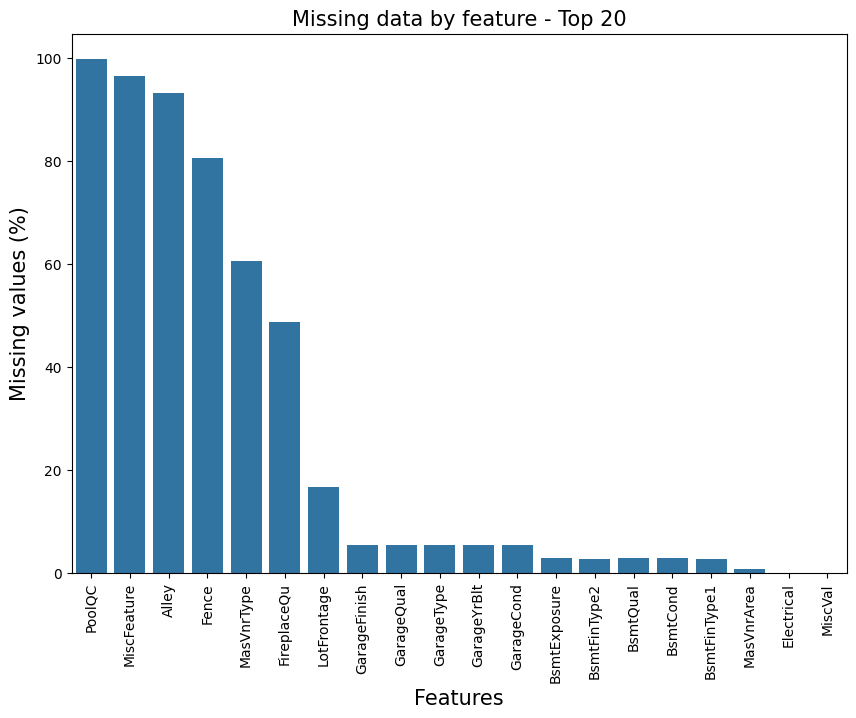

In [13]:
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='vertical')
sns.barplot(x=missing_df[:20].index, y=missing_df['Missingness - All'][:20])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Missing values (%)', fontsize=15)
plt.title('Missing data by feature - Top 20', fontsize=15)
plt.show()

In [14]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice', ylabel='Count'>

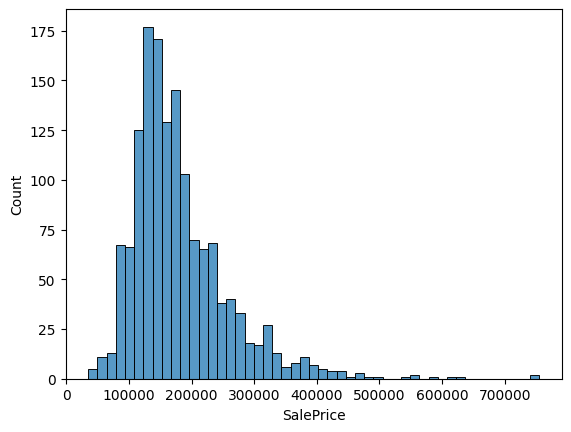

In [16]:
sns.histplot(train_df['SalePrice'])

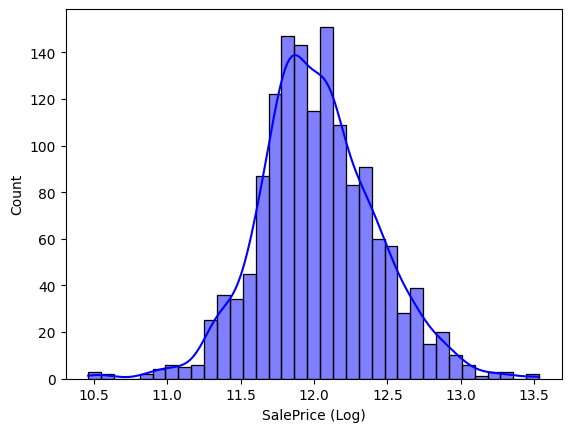

In [17]:
train_df['SalePrice (Log)'] = np.log(train_df['SalePrice'])
sns.histplot(train_df, x="SalePrice (Log)", kde=True, color='blue')
plt.show()

In [18]:
categorial_values = ['ExterQual', 'ExterCond', 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', \
                     'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'Fence',\
                     'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', \
                     'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', \
                     'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',  'Foundation', 'Heating', 'CentralAir', 'Electrical', \
                     'Functional',  'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType']

non_categorical_values = ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', \
                  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',\
                  'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', \
                  'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', \
                  'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'SalePrice (Log)']

In [19]:
train_df_dummy = pd.get_dummies(train_df[categorial_values], dtype=int)
test_df_dummy = pd.get_dummies(test_df[categorial_values], dtype=int)

train_df_final = pd.concat([train_df_dummy, train_df[non_categorical_values]], join='inner', axis=1)
test_df_final = pd.concat([test_df_dummy, test_df[non_categorical_values[:-2]]], join='inner', axis=1)

In [20]:
train_df_final.head()

,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,SalePrice (Log)
0,2003,2003,196.0,0,0,1,0,0,0,0,...,61,0,0,0,0,0,2,2008,208500,12.247694
1,1976,1976,0.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,5,2007,181500,12.109011
2,2001,2002,162.0,0,0,1,0,0,0,0,...,42,0,0,0,0,0,9,2008,223500,12.317167
3,1915,1970,0.0,0,0,0,1,0,0,0,...,35,272,0,0,0,0,2,2006,140000,11.849398
4,2000,2000,350.0,0,0,1,0,0,0,0,...,84,0,0,0,0,0,12,2008,250000,12.429216


In [21]:
train_columns = list(train_df_final.columns)
test_columns = list(test_df_final.columns)

imputer = KNNImputer(n_neighbors = 5)
train_df_final = pd.DataFrame(imputer.fit_transform(train_df_final), columns=train_columns)
test_df_final = pd.DataFrame(imputer.fit_transform(test_df_final), columns=test_columns)

train_df_final.head()

,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,SalePrice (Log)
0,2003.0,2003.0,196.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0,12.247694
1,1976.0,1976.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0,12.109011
2,2001.0,2002.0,162.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0,12.317167
3,1915.0,1970.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0,11.849398
4,2000.0,2000.0,350.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0,12.429216


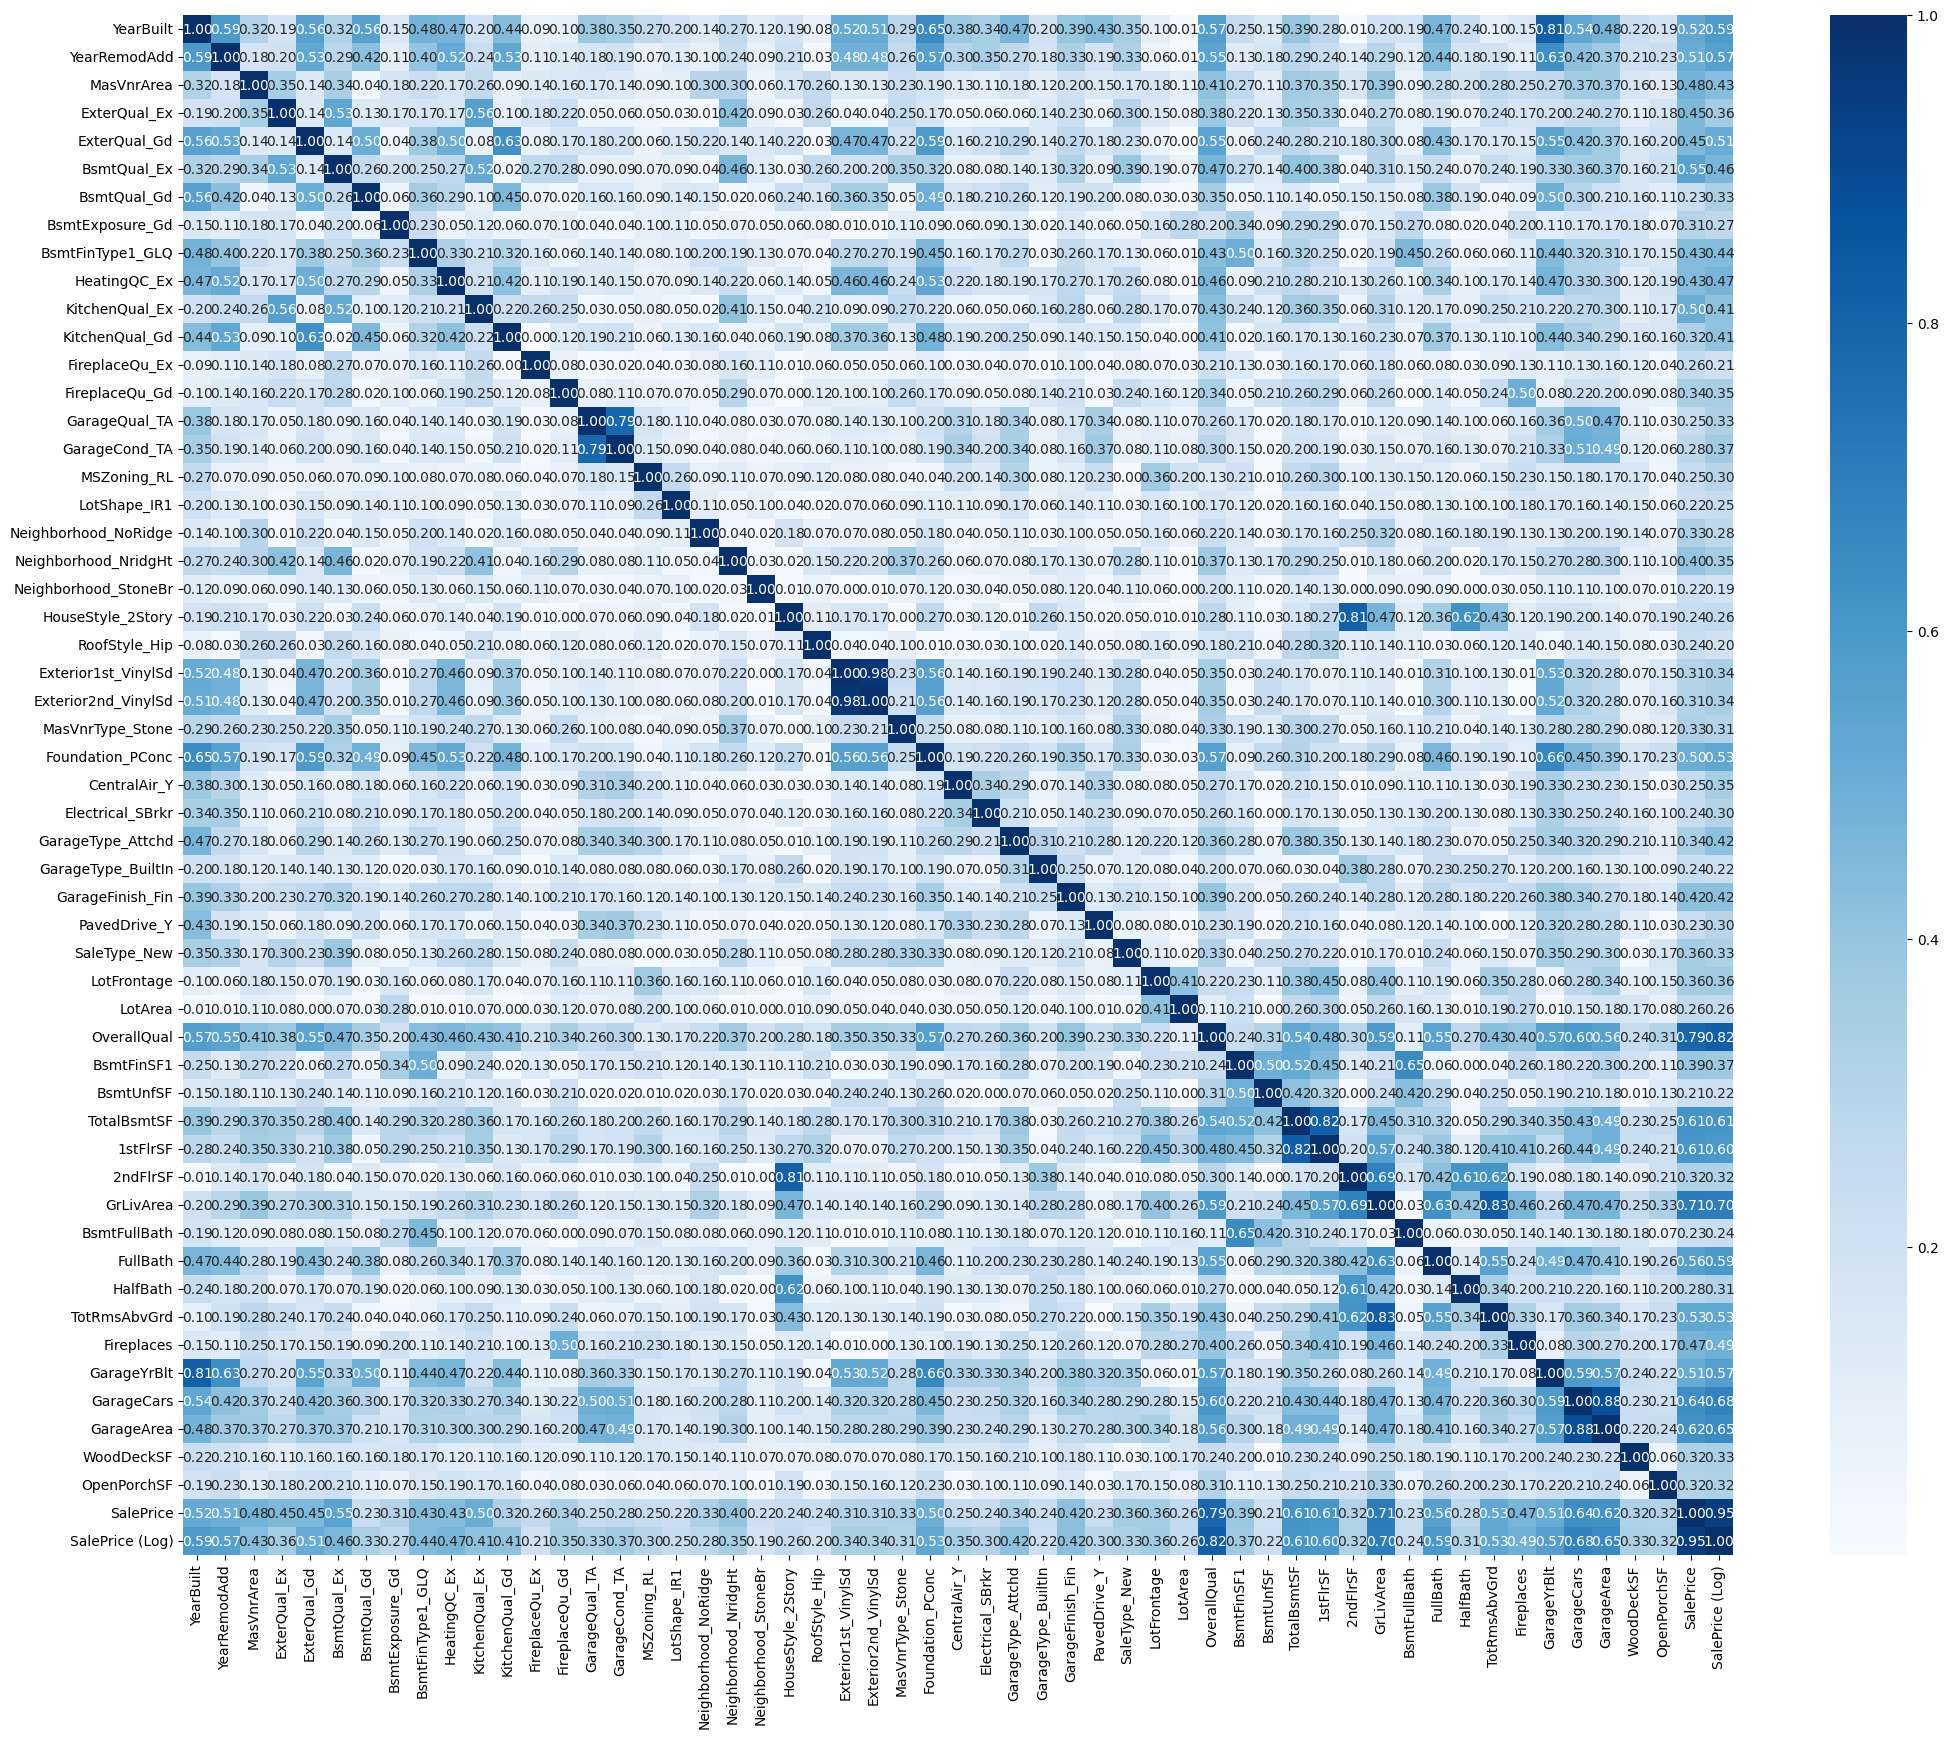

In [22]:
subset_corr_input_features = []
for column in train_df_final.columns:
    if np.corrcoef(train_df_final['SalePrice'],train_df_final[column])[0,1]>0.2:
        subset_corr_input_features.append(column)

f, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(np.abs(train_df_final[subset_corr_input_features].corr()), annot = True, fmt = ".2f", \
cmap="Blues")
plt.show()

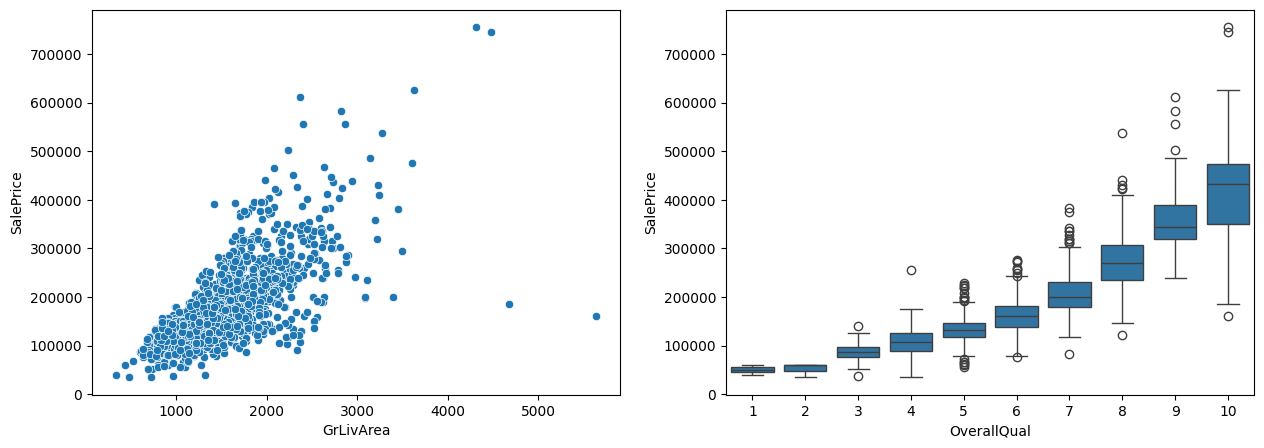

In [23]:
var1 = 'GrLivArea'
var2 = 'OverallQual'
data1 = pd.concat([train_df['SalePrice'], train_df[var1]], axis=1)
data2 = pd.concat([train_df['SalePrice'], train_df[var2]], axis=1)

fig,axs=plt.subplots(1,2,figsize=(15,5))

sns.scatterplot(data=data1, x=var1, y='SalePrice', ax=axs[0])
sns.boxplot(data=data2, x=var2, y='SalePrice', ax=axs[1])
plt.show()

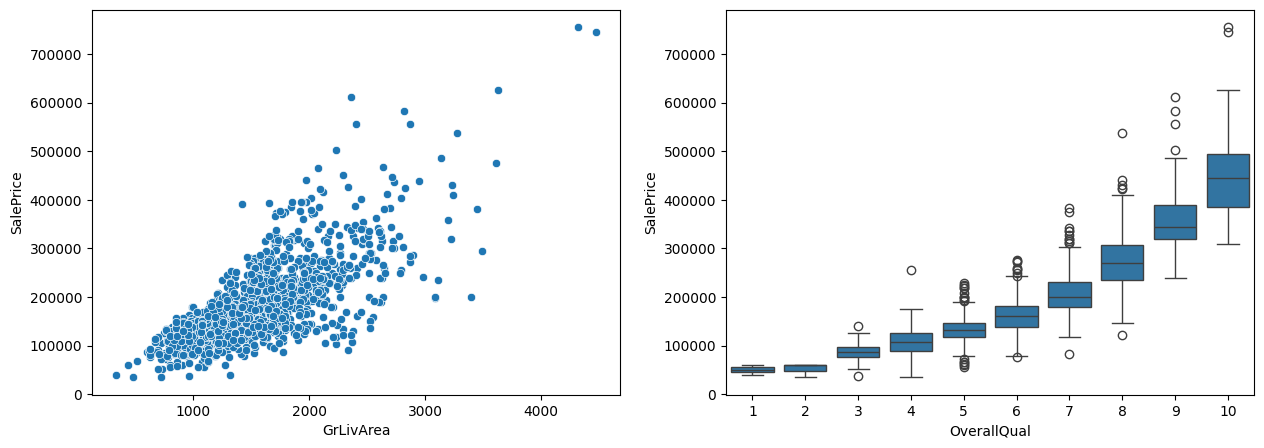

In [25]:
train_df = train_df[~((train_df["GrLivArea"] > 4000) & (train_df["SalePrice"] < 200000))]

var1 = 'GrLivArea'
var2 = 'OverallQual'
data1 = pd.concat([train_df['SalePrice'], train_df[var1]], axis=1)
data2 = pd.concat([train_df['SalePrice'], train_df[var2]], axis=1)

fig,axs=plt.subplots(1,2,figsize=(15,5))

sns.scatterplot(data=data1, x=var1, y='SalePrice', ax=axs[0])
sns.boxplot(data=data2, x=var2, y='SalePrice', ax=axs[1])
plt.show()

In [29]:
final_input_features = list(test_df_final.columns)

train_size = len(train_df)

train_core_df = train_df_final[:int(train_size*0.8)]
train_CV_df = train_df_final[int(train_size*0.8):]

X_train = train_core_df[final_input_features]
Y_train = train_core_df['SalePrice (Log)']

X_test = train_CV_df[final_input_features]
Y_test = train_CV_df['SalePrice (Log)']

classifier_list = [ElasticNet(), Lasso(), Ridge(), xgb.XGBRegressor(), GradientBoostingRegressor()]
model_list = ['Elastic Net', 'Lasso', 'Ridge', 'XGB', 'GBR']
r2_score_list = []
for classifier in classifier_list:
    model = classifier.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    r2_score_list.append(r2_score(Y_test, Y_pred))

df_results = pd.DataFrame(data={'Model':model_list,'$R^2$':r2_score_list})
df_results

,Model,$R^2$
0,Elastic Net,0.570798
1,Lasso,0.541774
2,Ridge,0.769663
3,XGB,0.877818
4,GBR,0.894454


In [32]:
X_train = train_df_final[final_input_features]
Y_train = train_df_final['SalePrice (Log)']

X_test = test_df_final[final_input_features]

model = GradientBoostingRegressor().fit(X_train,Y_train)
Y_pred_log = model.predict(X_test)
Y_pred = np.exp(Y_pred_log)

final_result = pd.DataFrame({'Id':test_df_final['Id'].astype(int), 'SalePrice':Y_pred})
final_result.to_csv('submission.csv', index=False)